In [110]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# run eagerly should be set to true. 
tf.config.run_functions_eagerly(True)

import copy

# %matplotlib notebook
# plt.rcParams['figure.figsize'] = [10, 10]


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df




def custom_loss(y_true, y_pred):

    def step_function(ae):
        return np.where(ae >= 0, 1, 0)
    
    def calculate_gain(y_true, y_pred):
        # Create 1 day shifted array for y value.
        y_true_shifted = np.append(y_true[0],y_true[:-1])
        y_pred_shifted = np.append(y_pred[0],y_pred[:-1])
        
        # Calculate gain from 1 day before.
        w_true = (y_true / y_true_shifted) - 1.0
        w_pred = (y_pred / y_pred_shifted) - 1.0
        
        return w_true, w_pred
    
    w_true, w_pred = calculate_gain(y_true, y_pred)

    diff = y_true - y_pred
    
    # Weighted mean absolute error
    wae = -1.0 * w_true * diff
    wmae = sum(wae) / wae.shape[0]
    
    return wmae


def custom_metric(y_true, y_pred):

    def step_function(ae):
        return np.where(ae >= 0, 1, 0)
    
    def calculate_gain(y_true, y_pred):
        # Create 1 day shifted array for y value.
        y_true_shifted = np.append(y_true[0],y_true[:-1])
        y_pred_shifted = np.append(y_pred[0],y_pred[:-1])
        
        # Calculate gain from 1 day before.
        w_true = (y_true / y_true_shifted) - 1.0
        w_pred = (y_pred / y_pred_shifted) - 1.0
        
#         w_true = np.where(abs(w_true) > 0.5, w_true/abs(w_true), w_true)
#         w_pred = np.where(abs(w_pred) > 0.5, w_true/abs(w_pred), w_pred)
        
        return w_true, w_pred
#         return np.nan_to_num(w_true, nan=0.0), np.nan_to_num(y_pred, nan=0.0)
    
    w_true, w_pred = calculate_gain(y_true, y_pred)
    
    w_true = (w_true/abs(w_true))*np.log(abs(w_true))
    w_pred = (w_pred/abs(w_pred))*np.log(abs(w_pred))

    diff = y_true - y_pred
    
    # Weighted mean absolute error
    wae = -1.0 * w_true * diff
    wmae = sum(wae) / wae.shape[0]
    
    return wmae


Num GPUs Available:  1


In [2]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
85816,34706.63,34710.47,34702.42,34702.42,56840.15,1.637821,42,25,31819.764,0.916871,34704.887,17,25020.389,0.720950,34704.594,2023-11-04 17:10:00
85817,34701.60,34714.00,34701.60,34706.48,52623.16,1.516309,40,23,29657.960,0.854578,34705.473,17,22965.209,0.661731,34704.688,2023-11-04 17:11:00
85818,34704.78,34709.32,34703.55,34709.32,66577.45,1.918363,49,25,33478.090,0.964630,34705.850,24,33099.363,0.953733,34705.035,2023-11-04 17:12:00
85819,34707.08,34720.79,34706.98,34709.88,48586.83,1.399843,45,31,31048.607,0.894547,34708.926,14,17538.229,0.505296,34709.050,2023-11-04 17:13:00
85820,34709.53,34715.90,34697.44,34715.86,53365.42,1.537331,40,7,7222.575,0.208078,34711.582,12,15509.651,0.446851,34707.848,2023-11-04 17:14:00


In [4]:
####################################
# Create Dataset with target value
####################################
predicting_points = 1
btc_df_with_target = btc_raw_df
target_column_to_predict = 'close'
target = btc_raw_df[target_column_to_predict].shift(-predicting_points)
btc_df_with_target['target'] = target
btc_df_with_target.tail(10)

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,target
85811,34697.92,34710.39,34697.92,34701.49,35522.86,1.023509,31,21,20273.682,0.584148,34705.367,10,15249.184,0.439361,34707.680,2023-11-04 17:05:00,34704.15
85812,34701.48,34704.55,34700.57,34704.15,37952.80,1.093691,33,20,26028.918,0.750076,34701.650,13,11923.884,0.343615,34701.535,2023-11-04 17:06:00,34707.12
85813,34703.63,34709.99,34699.25,34707.12,41651.32,1.200114,38,22,23114.213,0.665997,34706.297,16,18537.107,0.534117,34706.867,2023-11-04 17:07:00,34708.43
85814,34704.84,34708.54,34696.42,34708.43,46691.11,1.345295,40,14,22165.766,0.638656,34706.582,26,24525.348,0.706639,34706.310,2023-11-04 17:08:00,34707.04
85815,34716.89,34716.89,34706.41,34707.04,15976.32,0.460294,14,9,10927.166,0.314822,34710.355,5,5049.156,0.145472,34710.973,2023-11-04 17:09:00,34702.42
85816,34706.63,34710.47,34702.42,34702.42,56840.15,1.637821,42,25,31819.764,0.916871,34704.887,17,25020.389,0.720950,34704.594,2023-11-04 17:10:00,34706.48
85817,34701.60,34714.00,34701.60,34706.48,52623.16,1.516309,40,23,29657.960,0.854578,34705.473,17,22965.209,0.661731,34704.688,2023-11-04 17:11:00,34709.32
85818,34704.78,34709.32,34703.55,34709.32,66577.45,1.918363,49,25,33478.090,0.964630,34705.850,24,33099.363,0.953733,34705.035,2023-11-04 17:12:00,34709.88
85819,34707.08,34720.79,34706.98,34709.88,48586.83,1.399843,45,31,31048.607,0.894547,34708.926,14,17538.229,0.505296,34709.050,2023-11-04 17:13:00,34715.86
85820,34709.53,34715.90,34697.44,34715.86,53365.42,1.537331,40,7,7222.575,0.208078,34711.582,12,15509.651,0.446851,34707.848,2023-11-04 17:14:00,NaN


In [5]:
# Check if the target value is defined as the future close value.
btc_df_with_target[['close','target']].tail(10)

,close,target
85811,34701.49,34704.15
85812,34704.15,34707.12
85813,34707.12,34708.43
85814,34708.43,34707.04
85815,34707.04,34702.42
85816,34702.42,34706.48
85817,34706.48,34709.32
85818,34709.32,34709.88
85819,34709.88,34715.86
85820,34715.86,NaN


In [6]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,target
count,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820.000000,85820,85819.000000
mean,28439.350622,28446.425299,28432.438555,28439.864283,31101.873464,1.089580,27.297565,13.458646,15651.363723,0.547841,28440.082131,13.836472,15448.154707,0.541670,28439.205488,2023-10-04 08:35:14.302260480,28439.894750
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000173,2.000000,1.000000,0.026938,0.000001,24962.285000,1.000000,0.027108,0.000001,24974.842000,2023-09-02 12:11:00,24947.410000
25%,26493.727500,26498.055000,26489.730000,26493.760000,15771.790000,0.561672,14.000000,7.000000,7341.689125,0.258575,26494.292500,7.000000,7322.660975,0.258325,26494.035250,2023-09-19 05:07:45,26493.765000
50%,27117.080000,27123.030000,27110.990000,27117.780000,24106.645000,0.844993,22.000000,11.000000,12023.941250,0.425288,27117.817500,11.000000,12058.215000,0.426642,27117.089500,2023-10-04 11:36:30,27117.830000
75%,28735.662500,28747.010000,28727.035000,28739.405000,38419.785000,1.379380,33.000000,17.000000,19551.042000,0.695856,28737.359250,17.000000,19424.474500,0.690353,28736.008250,2023-10-20 00:13:15,28739.410000
max,35897.820000,35915.210000,35889.010000,35898.130000,601811.300000,22.802782,887.000000,613.000000,475487.720000,16.123856,35902.832000,376.000000,411043.200000,15.579352,35899.793000,2023-11-04 17:14:00,35898.130000
std,3019.509755,3022.279177,3016.864325,3019.692331,25868.465969,0.863635,21.588941,12.003480,14174.899914,0.473906,3019.836186,11.765059,13598.229992,0.459153,3019.380424,NaN,3019.696734


In [7]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 85820
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
target: 1


In [8]:
btc_df_with_target = btc_df_with_target.dropna()

# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 85819
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
target: 0


In [9]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,target
85815,34716.89,34716.89,34706.41,34707.04,15976.32,0.460294,14,9,10927.166,0.314822,34710.355,5,5049.156,0.145472,34710.973,34702.42
85816,34706.63,34710.47,34702.42,34702.42,56840.15,1.637821,42,25,31819.764,0.916871,34704.887,17,25020.389,0.720950,34704.594,34706.48
85817,34701.60,34714.00,34701.60,34706.48,52623.16,1.516309,40,23,29657.960,0.854578,34705.473,17,22965.209,0.661731,34704.688,34709.32
85818,34704.78,34709.32,34703.55,34709.32,66577.45,1.918363,49,25,33478.090,0.964630,34705.850,24,33099.363,0.953733,34705.035,34709.88
85819,34707.08,34720.79,34706.98,34709.88,48586.83,1.399843,45,31,31048.607,0.894547,34708.926,14,17538.229,0.505296,34709.050,34715.86


In [10]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close',
]
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(85819, 4)


array([[0.08009275, 0.07578216, 0.08170092, 0.08016185],
       [0.0802069 , 0.07578216, 0.08215964, 0.08019473],
       [0.08018589, 0.07534131, 0.08180671, 0.08018833],
       ...,
       [0.89076045, 0.88990714, 0.89171263, 0.89118067],
       [0.89105085, 0.88947821, 0.89189046, 0.89144001],
       [0.89126089, 0.89052945, 0.89220327, 0.89149115]])

In [11]:
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(85819, 4)


array([[0.08009275, 0.07578216, 0.08170092, 0.08016185],
       [0.0802069 , 0.07578216, 0.08215964, 0.08019473],
       [0.08018589, 0.07534131, 0.08180671, 0.08018833],
       ...,
       [0.89076045, 0.88990714, 0.89171263, 0.89118067],
       [0.89105085, 0.88947821, 0.89189046, 0.89144001],
       [0.89126089, 0.89052945, 0.89220327, 0.89149115]])

In [12]:
sc_target = MinMaxScaler(feature_range = (0,1))
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df['target'].to_frame())
print(dataset_target_scaled.shape)
dataset_target_scaled

(85819, 1)


array([[0.08019473],
       [0.08018833],
       [0.08028878],
       ...,
       [0.89144001],
       [0.89149115],
       [0.89203724]])

In [13]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i], dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (68645, 13)
X_test shape (17164, 13)


In [14]:
y_train

array([[0.08017372],
       [0.08020477],
       [0.0803107 ],
       ...,
       [0.4586566 ],
       [0.45915976],
       [0.45841095]])

In [111]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 512,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 512,return_sequences = False))
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'Adagrad',loss = custom_metric, metrics = ['mae', custom_metric] , run_eagerly=True)
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 1,
                        batch_size = 128,
                        validation_split=0.3, 
                        shuffle=False, 
                        callbacks=[callback])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 13, 512)           1052672   
                                                                 
 dropout_22 (Dropout)        (None, 13, 512)           0         
                                                                 
 lstm_45 (LSTM)              (None, 512)               2099200   
                                                                 
 dense_22 (Dense)            (None, 1)                 513       
                                                                 
Total params: 3152385 (12.03 MB)
Trainable params: 3152385 (12.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
209/376 [===============>..............] - ETA: 9s - loss: nan - mae: nan - custom_metric: nan

KeyboardInterrupt: 

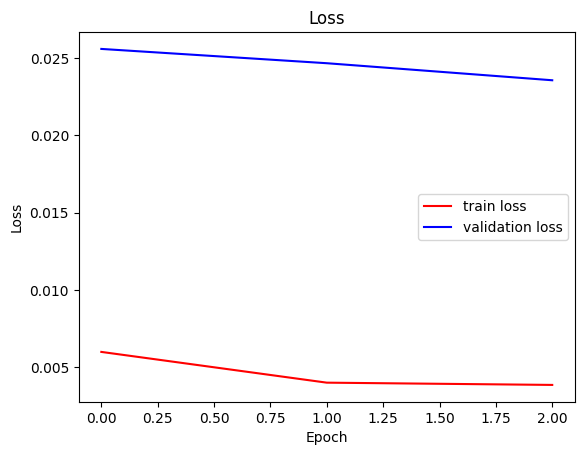

In [57]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history, color = 'red', label = 'train loss')
plt.plot(val_loss_history, color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

537/537 [==============================] - 2s 4ms/step
predicted_price shape: (17163, 1)
real_price shape: (17163, 1)


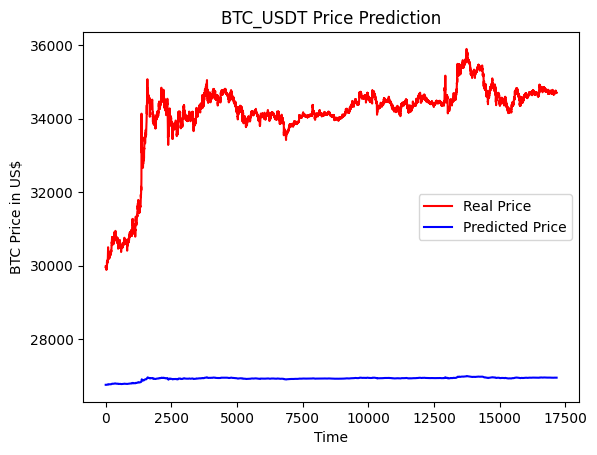

In [58]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_points]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_points]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

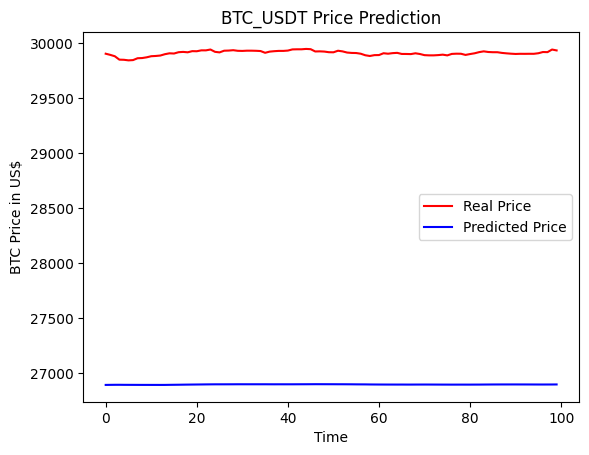

In [76]:

plt.plot(real_price[:100], color = 'red', label = 'Real Price')
plt.plot(predicted_price[:100], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

In [77]:
mse = metrics.mean_squared_error(real_price.reshape(real_price.shape[0]),
                   predicted_price.reshape(predicted_price.shape[0]))
print('mse:',mse)

mse: 45505113.82392377


In [79]:
real_price.reshape(real_price.shape[0])

array([29906.81, 29896.3 , 29883.75, ..., 34730.64, 34736.18, 34733.62])

In [51]:
predicted_price

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [77]:

def custom_loss(y_true, y_pred):
    def step_function(ae):
        return np.where(ae >= 0, 1, 0)
    
    def calculate_gain(y_true, y_pred):
        # Create 1 day shifted array for y value.
        y_true_shifted = np.append(y_true[0],y_true[:-1])
        y_pred_shifted = np.append(y_pred[0],y_pred[:-1])
        
        # Calculate gain from 1 day before.
        w_true = (y_true / y_true_shifted) - 1.0
        w_pred = (y_pred / y_pred_shifted) - 1.0
        
#         w_true = np.where(abs(w_true) > 0.5, w_true/abs(w_true), w_true)
#         w_pred = np.where(abs(w_pred) > 0.5, w_true/abs(w_pred), w_pred)
        
        return w_true, w_pred
#         return np.nan_to_num(w_true, nan=0.0), np.nan_to_num(y_pred, nan=0.0)
    
    w_true, w_pred = calculate_gain(y_true, y_pred)

    diff = y_true - y_pred
    
    # Weighted mean absolute error
    wae = -1.0 * w_true * diff
    wmae = sum(wae) / wae.shape[0]
    
    return wmae, w_true, w_pred, wae, diff

index_from = 0
batch_size = 128
while index_from+batch_size < y_test.shape[0]:
    
    real_price = y_test[index_from:index_from+batch_size]
    predicted_price = regressor.predict(X_test[index_from:index_from+batch_size])
    
    y_true = real_price.reshape(real_price.shape[0])
    y_pred = predicted_price.reshape(predicted_price.shape[0])
    
    wmae, w_true, w_pred, wae, diff = custom_loss(y_true, y_pred)
    print('wmae:', wmae)
    index_from+=batch_size

4/4 [==============================] - 0s 4ms/step
wmae: -0.014320892763815407
4/4 [==============================] - 0s 4ms/step
wmae: -0.024161680529188295
4/4 [==============================] - 0s 4ms/step
wmae: -0.007068402451048911
4/4 [==============================] - 0s 4ms/step
wmae: 0.009798145303062304
4/4 [==============================] - 0s 4ms/step
wmae: 0.0027836734208505107
4/4 [==============================] - 0s 4ms/step
wmae: -0.005232940818020191
4/4 [==============================] - 0s 4ms/step
wmae: -0.011926297014341072
4/4 [==============================] - 0s 4ms/step
wmae: -0.017812477931514484
4/4 [==============================] - 0s 4ms/step
wmae: -0.006336858813439971
4/4 [==============================] - 0s 4ms/step
wmae: -0.012591019473540235
4/4 [==============================] - 0s 4ms/step
wmae: -0.07139832051489124
4/4 [==============================] - 0s 4ms/step
wmae: -0.02813588067851855
4/4 [==============================] - 0s 4ms/step
wmae

4/4 [==============================] - 0s 4ms/step
wmae: -0.023884221017166352
4/4 [==============================] - 0s 4ms/step
wmae: -0.00660070049984099
4/4 [==============================] - 0s 4ms/step
wmae: -0.002614390694923252
4/4 [==============================] - 0s 4ms/step
wmae: -0.0012201735449168876
4/4 [==============================] - 0s 4ms/step
wmae: 0.01159592667821985
4/4 [==============================] - 0s 4ms/step
wmae: -0.0024450109350365647
4/4 [==============================] - 0s 4ms/step
wmae: -0.003541222830220464
4/4 [==============================] - 0s 4ms/step
wmae: -0.0006890603040355512
4/4 [==============================] - 0s 4ms/step
wmae: 0.015268265660645592
4/4 [==============================] - 0s 4ms/step
wmae: 0.008526089094766636
4/4 [==============================] - 0s 4ms/step
wmae: -0.010236693975405758
4/4 [==============================] - 0s 4ms/step
wmae: 0.010970323994782273
4/4 [==============================] - 0s 4ms/step
wmae

In [78]:
wmae

0.0011263446414997301

In [79]:
w_true

array([ 0.00000000e+00, -6.63321103e-04, -1.26308986e-03, -8.80672916e-05,
        1.12654131e-04,  2.06850648e-04,  1.88788966e-03,  6.76479364e-04,
       -4.18684351e-05, -2.17520733e-04, -1.42083178e-03, -3.23236291e-03,
        1.96007401e-04,  1.92890943e-04,  5.19063798e-04, -6.15171356e-05,
       -7.98746614e-04, -3.09902832e-04, -9.05361031e-04, -4.57200392e-04,
       -3.98819986e-04, -1.36043649e-03, -3.36711084e-04,  2.58541128e-04,
       -5.39603721e-04,  1.70314221e-03,  8.17722883e-04, -9.54772165e-04,
        6.37808900e-05,  1.20764499e-03, -9.58580684e-04, -1.82438777e-03,
        1.77723837e-03,  6.99349605e-05,  2.35499794e-04, -1.07954832e-04,
        1.42104462e-03,  3.47672157e-03, -5.00362225e-04, -8.49710740e-04,
        5.12309254e-05,  3.84212257e-04,  2.07907022e-04,  1.22875156e-05,
       -9.71725750e-04,  5.43219797e-05,  1.40922009e-03, -7.01059880e-04,
        1.55672788e-04, -4.91521762e-05, -1.34151075e-04, -2.98039698e-04,
       -2.29999518e-03,  

In [80]:
w_pred

array([ 0.0000000e+00, -2.9802322e-06, -5.0663948e-06, -1.7881393e-06,
       -5.3644180e-06,  4.7683716e-07, -6.5565109e-07,  2.7418137e-06,
        3.0994415e-06,  7.1525574e-07,  1.5497208e-06, -3.7550926e-06,
       -6.4969063e-06, -9.2387199e-06,  2.8610229e-06,  3.0994415e-06,
        7.1525574e-07, -2.1457672e-06, -2.9802322e-06, -3.4570694e-06,
       -3.7550926e-06, -2.6226044e-06, -2.2649765e-06, -4.1127205e-06,
       -8.3446503e-07, -1.4901161e-06,  2.3841858e-06, -1.7881393e-07,
        9.5367432e-07, -2.3245811e-06,  1.5497208e-06, -1.7881393e-07,
       -1.9669533e-06,  2.3841858e-07,  5.9604645e-07,  1.1920929e-06,
        0.0000000e+00,  2.8610229e-06,  8.7022781e-06,  5.0067902e-06,
       -9.5367432e-07, -2.9802322e-07,  1.4305115e-06,  9.5367432e-07,
        2.8610229e-06, -1.3113022e-06,  5.9604645e-07,  4.2915344e-06,
       -8.3446503e-07, -1.7881393e-06,  7.1525574e-07, -3.5762787e-07,
       -3.5762787e-07, -2.6226044e-06, -4.7087669e-06, -1.1920929e-07,
      

In [81]:
wae

array([-0.00000000e+00,  2.75153320e-02,  5.23927539e-02,  3.65300308e-03,
       -4.67284415e-03, -8.58011660e-03, -7.83123511e-02, -2.80618110e-02,
        1.73679595e-03,  9.02320887e-03,  5.89373162e-02,  1.34071354e-01,
       -8.12994151e-03, -8.00063891e-03, -2.15297809e-02,  2.55161837e-03,
        3.31300031e-02,  1.28538783e-02,  3.75509324e-02,  1.89626832e-02,
        1.65411158e-02,  5.64225085e-02,  1.39645661e-02, -1.07226051e-02,
        2.23789775e-02, -7.06368599e-02, -3.39152657e-02,  3.95986025e-02,
       -2.64528018e-03, -5.00876451e-02,  3.97568274e-02,  7.56629299e-02,
       -7.37101577e-02, -2.90052601e-03, -9.76731944e-03,  4.47740582e-03,
       -5.89393449e-02, -1.44211905e-01,  2.07546186e-02,  3.52448390e-02,
       -2.12498908e-03, -1.59367288e-02, -8.62381962e-03, -5.09677079e-04,
        4.03057361e-02, -2.25319450e-03, -5.84541441e-02,  2.90794964e-02,
       -6.45721973e-03,  2.03879892e-03,  5.56448360e-03,  1.23623741e-02,
        9.53966382e-02, -

In [82]:
diff

array([41.4818796 , 41.48116488, 41.47983111, 41.47968009, 41.4795631 ,
       41.47976664, 41.48142385, 41.482139  , 41.48222744, 41.48206345,
       41.48085425, 41.47781601, 41.47772721, 41.47752505, 41.47810156,
       41.47817266, 41.47748799, 41.47712447, 41.47619697, 41.47564946,
       41.47514256, 41.47382761, 41.47343745, 41.47349881, 41.47298597,
       41.47443442, 41.47525577, 41.4743998 , 41.47449456, 41.47547127,
       41.4746803 , 41.47305269, 41.47454782, 41.47462136, 41.47485337,
       41.47480707, 41.47606909, 41.47927938, 41.4791876 , 41.47863184,
       41.47863935, 41.47897035, 41.47921295, 41.47926205, 41.47850988,
       41.47850488, 41.47978339, 41.47933334, 41.47943781, 41.4793215 ,
       41.47923239, 41.47895139, 41.47688604, 41.4769436 , 41.477372  ,
       41.47736728, 41.47793105, 41.47760607, 41.47657406, 41.47635884,
       41.47636382, 41.47700648, 41.47689846, 41.47861386, 41.47823377,
       41.47908316, 41.4792303 , 41.47908647, 41.48001608, 41.47